In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
import random
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import utils
import h5py
import time
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(7)
'''
Based on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb
See: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf
for possible implementation into FPGA
'''

'\nBased on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb\nSee: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf\nfor possible implementation into FPGA\n'

In [21]:
def plot_loss(data, title,yscale="linear"):     
    """ Plots the training and validation loss yscale can be: linear,log,symlog """
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history["loss"])#, linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history["val_loss"])#, linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"])#, loc="upper right", frameon=False)
    plt.yscale(yscale)
    plt.show();

In [22]:
class Pulse:
    '''
    A class that generates a Pulse that includes both Cerenkov and Scintillation Pulse. The pulse is randomly generated 
    through the use of a probability density function that is generated by the given parameters.
    The pulse has 512 samples and is identifiable by 3 parameters:
        1) ratio: If ratio is positive, it is the ratio of the Area of Cernekov:Area of Scintillation. 
                  If ratio is negative, it is the ratio of the Area of Scintillation:Area of Cerenkov
                
        This is altered by changing the height of the Cerenkov pulse (Cerenkov Radiation).
        
        
        2) separation: Time between the two pulses
       
    '''
    
    
    
    def __init__(self, photoelectrons, ratio, scint_decay):
        self.start=10
        self.rise=0.05
        self.cerenkov_decay=2.5
        self.scint_decay=scint_decay
        
        self.end_time=250
        self.timestep=0.1
        self.t=t=np.arange(0,self.end_time,self.timestep)
        self.bin_number=100
        

        if ratio>0:
            self.ratio=ratio
        else:
            self.ratio=-(1/ratio)
            
        self.photoelectrons=photoelectrons
        self.cerenkov_strength=self.ratio
        #self.cerenkov_percent=self.ratio/(self.ratio+1)
        #self.scint_percent=1/(self.ratio+1)
        self.interp=self.interpolator()
        self.cerenkov_area=sp.integrate.quad(self.cerenkov_scaled, self.start, self.end_time)
        self.scint_area=sp.integrate.quad(self.scintillation_normalized, self.start, self.end_time)
        
        self.cerenkov_percent=(self.cerenkov_area[0])/(self.cerenkov_area[0]+self.scint_area[0])
        self.scint_percent=(self.scint_area[0])/(self.cerenkov_area[0]+self.scint_area[0])
 
    def cerenkov(self,t):
        return (1-np.exp(-((t-self.start)/self.rise)))*(np.exp(-((t-self.start)/self.cerenkov_decay)))

    def scintillation(self, t):
        return (1-np.exp(-((t-self.start)/self.rise)))*(np.exp(-((t-self.start)/self.scint_decay)))
    
    def cerenkov_scaled(self, t):
        cerenkov=self.cerenkov(t)
        norm=sp.integrate.quad(self.cerenkov, self.start, self.end_time)
        return (1/norm[0])*self.cerenkov_strength*cerenkov
    
    def scintillation_normalized(self, t):
        scint=self.scintillation(t)
        norm=sp.integrate.quad(self.scintillation, self.start, self.end_time)
        return (1/norm[0])*scint


    def pulse_func_helper(self, time):
        if time<self.start:
            return 0
        else:
            return self.cerenkov_scaled(time) + self.scintillation_normalized(time) 
    
    
    def pulse_func(self, t):
        pulse=[]
                        
        for time in t:
            pulse.append(self.pulse_func_helper(time))
        return np.asarray(pulse)


    def randomValues(self,number):
        val=[]
        for x in range(number):
            val.append(random.random())
        return val

    
    def graph_both_pulses(self):
        t=np.arange(self.start,self.end_time,self.timestep)
        plt.figure()
        plt.plot(t, self.cerenkov_scaled(t), c='r', label="cerenkov")
        plt.plot(t, self.scintillation_normalized(t), label='scintillation')
        plt.xlabel("Time (ns)")
        plt.title("Pulse with ratio "+ str(self.ratio)+ " and scint decay "+str(self.scint_decay))
        plt.legend()
    
    def final_pdf(self, t):
        radiation=self.pulse_func(t)
        norm=sp.integrate.quad(self.pulse_func_helper, 0, self.end_time)
        return (1/norm[0])*radiation
    
    def graph_pdf(self):
        plt.figure()
        plt.plot(self.t, self.final_pdf(self.t))
        plt.xlabel("Time (ns)")
        plt.title("Pulse with ratio "+ str(self.ratio)+ " and scint decay "+str(self.scint_decay))

    def final_cdf(self, t):
        prob=self.final_pdf(t)
        return np.cumsum(prob)*self.timestep
    
    def interpolator(self):
        cumul=self.final_cdf(self.t)
        hits=self.photoelectrons
        #print(hits)
        rand=self.randomValues(hits)
        #print(rand)
        interp=sp.interpolate.interp1d(cumul,self.t, fill_value="extrapolate")
        return interp
    
    def output(self):
        hits=self.photoelectrons
        #print(hits)
        rand=self.randomValues(hits)
        vals=self.interp(rand)
        hist, bin_edges=np.histogram(vals, bins=self.bin_number, range=(0,self.end_time))
        return hist, self.cerenkov_percent, self.scint_percent
        

    
    '''
    DEPRECAYED FUNCTIONS
    def final_distribution(self):
        cumul=self.final_cdf(self.t)
        hits=self.photoelectrons
        #print(hits)
        rand=self.randomValues(hits)
        #print(rand)
        interp=sp.interpolate.interp1d(cumul,self.t, fill_value="extrapolate")
        vals=interp(rand)
        #print(vals)
        return vals
        
    def histogram_generator(self):
        data=self.final_distribution()
        hist, bin_edges=np.histogram(data, bins=self.bin_number, range=(0,self.end_time))
        #print(bin_edges)
        return hist
    
    def output(self):
        
        
        return self.histogram_generator(), self.cerenkov_percent, self.scint_percent
    '''
    


In [23]:
class PulseLibrary:
    '''
    Creates a list of pulses with the attached ratio.
    labels has form of ratioXXXscint_decayXXeventXX
    '''
    
    def __init__(self, seed, name, eventsperexperiment, photoelectrons,ratios=[1],scint_decays=[50]):
        np.random.seed(seed)
        self.name=name +'.hdf5'
        self.scint_decays=scint_decays
        self.ratios=ratios
        self.photoelectrons=photoelectrons
        self.eventsperexperiment=eventsperexperiment
        self.labels=[]
        self.pulses=[]
        self.inputs=[]
        self.outputs=[]
        
        
        
        file=h5py.File(self.name, 'w')
        
        for ratio in self.ratios:
            for scint_decay in self.scint_decays:
                pulse=Pulse(self.photoelectrons, ratio, scint_decay)
                
                group_name="ratio"+str(ratio)+"scintdecay"+str(scint_decay)
                
                group = file.create_group(group_name)
                
                for i in range(eventsperexperiment):
                    
                    self.pulses.append(pulse)
                    ins, out1, out2=pulse.output()
                    outs=[out1, out2]
                    
                    
                    label="ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"event"+str(i)
                    self.labels.append(label)
                    self.inputs.append(ins)
                    self.outputs.append(outs)
                    
                    subgroup=group.create_group(label)
                    
                    
                    d1 = subgroup.create_dataset(label+'input', data=ins)
                    d2 = subgroup.create_dataset(label+'output', data=outs)
                    
        
        file.close()
    
    def get_inputs(self):
        return np.asarray(self.inputs)
    
    def get_outputs(self):
        return np.asarray(self.outputs)
    
    def get_labels(self):
        return self.labels
    
    def get_pulses(self):
        return np.asarray(self.pulses)

In [24]:
integration_vals=[1.25, 3.75, 6.25, 8.75, 11.25, 13.75, 16.25, 18.75, 21.25, 23.75, 26.25, 28.75, 31.25, 33.75, 36.25, 38.75, 41.25, 43.75, 46.25, 48.75, 51.25, 53.75, 56.25, 58.75, 61.25, 63.75, 66.25, 68.75, 71.25, 73.75, 76.25, 78.75, 81.25, 83.75, 86.25, 88.75, 91.25, 93.75, 96.25, 98.75, 101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75, 181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75, 201.25, 203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75, 221.25, 223.75, 226.25, 228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75, 246.25, 248.75]

In [25]:
def model_creator():
    model = Sequential()
    #model.add(Dense(50,  input_shape=(300,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_shape=(30,), kernel_initializer='ones', activation='relu'))
    model.add(Dense(2, kernel_initializer='ones', activation='relu'))
# Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def model_trainer(pulse_library, model_name):
    model=model_creator()
    file=h5py.File(pulse_library, 'r')
    X=[]
    Y=[]
    for groups in file.values():
        for subgroup in groups.values():
            for event in subgroup.values():
                #if not "ratio0.0scint"in event.name:
                #if 'event0' in event.name:  
                if event.name[-5:]=="input":
                    data=event[:]
                    data=np.asarray(data)                      
                    X.append(data)
                    #X.append(data)
                elif event.name[-6:]=="output":
                    Y.append(event[:])
    file.close()    
    X=np.asarray(X)

    Y=np.asarray(Y)
    norm_factor=np.amax(X)
    X_scaled=X/norm_factor
    Xtrain, Xval, Ytrain, Yval = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
    checkpointer = ModelCheckpoint(filepath=model_name+"weights.hdf5",verbose=3, save_best_only=True)
    earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50 ,verbose=1, mode='auto')
    history=model.fit(Xtrain,Ytrain,epochs=200,verbose=1
                             ,validation_data=(Xval,Yval)
                             ,shuffle=True, batch_size=16
                             ,callbacks=[earlystop,checkpointer])
    model.save(model_name)
    return model, history

def model_verifier(pulse_library, model_name, ratios, scint_decays, eventsperexperiment):
    model=load_model(model_name)
    file=h5py.File(pulse_library, 'r')
    X=[]
    Y=[]
    labels=[]
    
    for ratio in ratios:
        for scint_decay in scint_decays:
            tempX=[]
            tempY=[]
            templabels=[]
            for i in range(eventsperexperiment):
                label="/ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"/ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"event"+str(i)+"/ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"event"+str(i)
                #print(label)
                Xdata=file[label+"input"][:]
                Ydata=file[label+"output"][:]
                Xdata=np.asarray(Xdata)
                
                tempX.append(Xdata)
                tempY.append(Ydata)
                templabels.append(label)
            X.append(tempX)
            Y.append(tempY)
            labels.append(templabels)
    
    file.close()
    X=np.asarray(X)
    Y=np.asarray(Y)
    results=[]
    norm_factor=np.amax(X)
    X_scaled=X/norm_factor
    
    for x in X_scaled:
        prediction=model.predict(x)
        results.append(prediction)

    results=np.array(results)
    #results=model.predict(X)
    return results, Y, labels
    
    
    '''
    deprecated
    for groups in file.values():
        tempX=[]
        tempY=[]
        templabels=[]
        for subgroup in groups.values():
            
            for event in subgroup.values():
                if event.name[-5:]=="input":
                    tempX.append(event)
                    templabels.append(event.name)
                elif event.name[-6:]=="output":
                    tempY.append(event)
        X.append(tempX)
        Y.append(tempY)
        labels.append(templabels)
            
    X=np.asarray(X)
    Y=np.asarray(Y)
    results=[]
    for x in X:
        prediction=model.predict(x)
        results.append(prediction)
    results=np.array(results)
    #results=model.predict(X)
    return results, Y, labels
    '''

# 10,000 photoelectrons

Train on 160000 samples, validate on 40000 samples
Epoch 1/200
160000/160000 [==============================] - 34s 214us/step - loss: 2.0360 - val_loss: 0.1183

Epoch 00001: val_loss improved from inf to 0.11826, saving model to NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5weights.hdf5
Epoch 2/200
160000/160000 [==============================] - 32s 198us/step - loss: 0.0018 - val_loss: 8.3125e-05

Epoch 00002: val_loss improved from 0.11826 to 0.00008, saving model to NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5weights.hdf5
Epoch 3/200
160000/160000 [==============================] - 32s 199us/step - loss: 8.8834e-05 - val_loss: 8.2763e-05

Epoch 00003: val_loss improved from 0.00008 to 0.00008, saving model to NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5weights.hdf5
Epoch 4/200
160000/160000 [==============================] - 35s 216us/step - loss: 8.7296e-05 - val_loss: 8.0696

160000/160000 [==============================] - 26s 163us/step - loss: 6.8104e-05 - val_loss: 6.2533e-05

Epoch 00084: val_loss improved from 0.00006 to 0.00006, saving model to NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5weights.hdf5
Epoch 85/200
160000/160000 [==============================] - 25s 156us/step - loss: 6.8066e-05 - val_loss: 7.2450e-05

Epoch 00085: val_loss did not improve from 0.00006
Epoch 86/200
160000/160000 [==============================] - 27s 172us/step - loss: 6.7988e-05 - val_loss: 7.2396e-05

Epoch 00086: val_loss did not improve from 0.00006
Epoch 87/200
160000/160000 [==============================] - 21s 129us/step - loss: 6.8006e-05 - val_loss: 6.3140e-05

Epoch 00087: val_loss did not improve from 0.00006
Epoch 88/200
160000/160000 [==============================] - 21s 128us/step - loss: 6.8211e-05 - val_loss: 6.3137e-05

Epoch 00088: val_loss did not improve from 0.00006
Epoch 89/200
160000/160000 [================

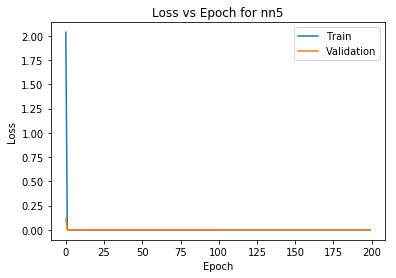

In [7]:
nn5_scint_decays=np.linspace(15,50,20)
nn5_ratios=np.linspace(-25,25,20)
nn5_eventsperexperiment=500
nn5_model,nn5_history=model_trainer('FinerParameterSpace500events10000photons30binsTrainingLibrary_20x20.hdf5', 'NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5')
plot_loss(data=nn5_history,title="Loss vs Epoch for nn5",yscale='linear')


In [26]:
nn5_scint_decays=np.linspace(15,50,10)
nn5_ratios=np.linspace(-25,25,10)
nn5_eventsperexperiment=500
nn5_results, nn5_actual_values, nn5_labels=model_verifier('FinerParameterSpace500events10000photons30binsTestingLibrary_20x20.hdf5','NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5', nn5_ratios,nn5_scint_decays,nn5_eventsperexperiment)

KeyError: 'Unable to open object (component not found)'

In [27]:
nn5_profile=2*(nn5_results-nn5_actual_values)/(nn5_results+nn5_actual_values)
nn5_sum_to_one=[]
nn5_profile=np.asarray(nn5_profile)
nn5_profile_labels=[]
nn5_profile_cerenkov_mean=[]
nn5_profile_scintillation_mean=[]
nn5_profile_cerenkov_stdev=[]
nn5_profile_scintillation_stdev=[]
for i in range(len(nn5_profile)):
    #print(len([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_mean.append(np.mean([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_stdev.append(np.std([item[0] for item in nn5_profile[i]]))
    nn5_profile_scintillation_mean.append(np.mean([item[1] for item in nn5_profile[i]]))
    nn5_profile_scintillation_stdev.append(np.std([item[1] for item in nn5_profile[i]]))
    nn5_profile_labels.append(nn5_labels[i][0])
    nn5_sum_to_one.append(np.mean([item[0]+item[1] for item in nn5_results[i]]))

nn5_profile_labels_clean=[]
for label in nn5_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn5_profile_labels_clean.append(label[1:index])

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean)
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev)
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean)
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev)
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean)
nn5_sum_to_one=np.asarray(nn5_sum_to_one)

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean.reshape(10,10))
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev.reshape(10,10))
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean.reshape(10,10))
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev.reshape(10,10))
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean.reshape(10,10))
nn5_sum_to_one=np.asarray(nn5_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn5_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn5_profile_cerenkov_mean, nn5_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn5_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, nn5_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_scintillation_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_scintillation_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=5)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
#plt.clim(-1,1)
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)

plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_cerenkov_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_cerenkov_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=5)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)


ValueError: cannot reshape array of size 400 into shape (10,10)

# 10,000 photon model on 5,000

In [34]:
nn5_scint_decays=np.linspace(15,50,10)
nn5_ratios=np.linspace(-25,25,10)
nn5_eventsperexperiment=500
nn5_results, nn5_actual_values, nn5_labels=model_verifier('FinerParameterSpace500events5000photons30binsTestingLibrary.hdf5','NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5', nn5_ratios,nn5_scint_decays,nn5_eventsperexperiment)


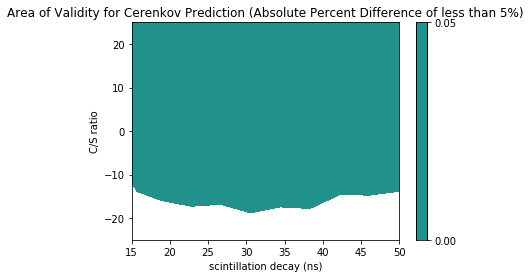

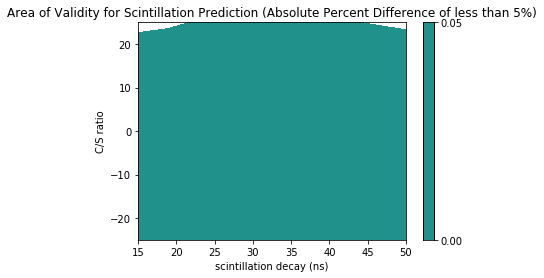

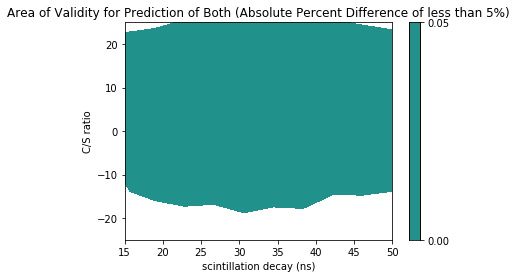

<Figure size 432x288 with 0 Axes>

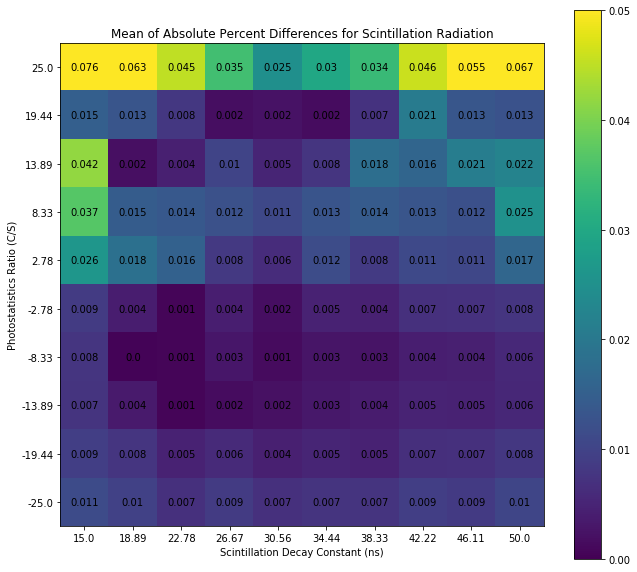

<Figure size 432x288 with 0 Axes>

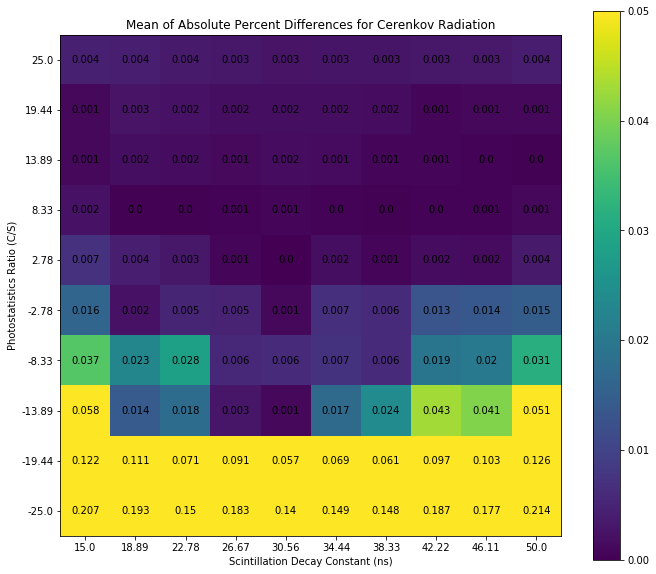

In [35]:
nn5_profile=2*(nn5_results-nn5_actual_values)/(nn5_results+nn5_actual_values)
nn5_sum_to_one=[]
nn5_profile=np.asarray(nn5_profile)
nn5_profile_labels=[]
nn5_profile_cerenkov_mean=[]
nn5_profile_scintillation_mean=[]
nn5_profile_cerenkov_stdev=[]
nn5_profile_scintillation_stdev=[]
for i in range(len(nn5_profile)):
    #print(len([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_mean.append(np.mean([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_stdev.append(np.std([item[0] for item in nn5_profile[i]]))
    nn5_profile_scintillation_mean.append(np.mean([item[1] for item in nn5_profile[i]]))
    nn5_profile_scintillation_stdev.append(np.std([item[1] for item in nn5_profile[i]]))
    nn5_profile_labels.append(nn5_labels[i][0])
    nn5_sum_to_one.append(np.mean([item[0]+item[1] for item in nn5_results[i]]))

nn5_profile_labels_clean=[]
for label in nn5_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn5_profile_labels_clean.append(label[1:index])

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean)
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev)
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean)
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev)
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean)
nn5_sum_to_one=np.asarray(nn5_sum_to_one)

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean.reshape(10,10))
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev.reshape(10,10))
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean.reshape(10,10))
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev.reshape(10,10))
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean.reshape(10,10))
nn5_sum_to_one=np.asarray(nn5_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn5_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn5_profile_cerenkov_mean, nn5_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn5_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, nn5_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_scintillation_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_scintillation_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
#plt.clim(-1,1)
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)

plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_cerenkov_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_cerenkov_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)


In [36]:
# max_error=np.asarray(nn5_max_error)
print(max_error)
np.where(max_error < 0.05)

NameError: name 'max_error' is not defined

# 10,000 photon model on 1,000

In [37]:
nn5_results, nn5_actual_values, nn5_labels=model_verifier('FinerParameterSpace500events1000photons30binsTestingLibrary.hdf5','NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5', nn5_ratios,nn5_scint_decays,nn5_eventsperexperiment)


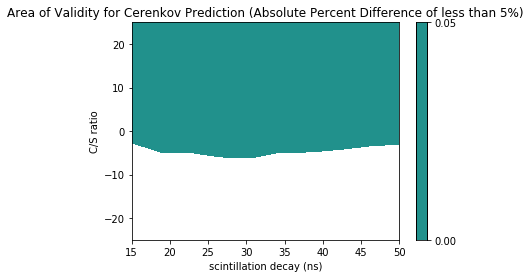

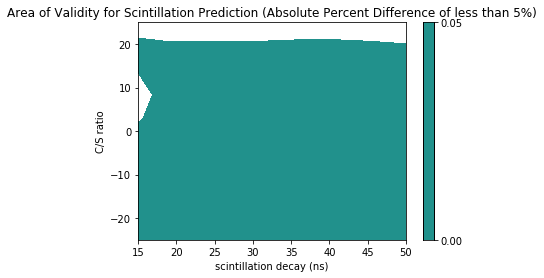

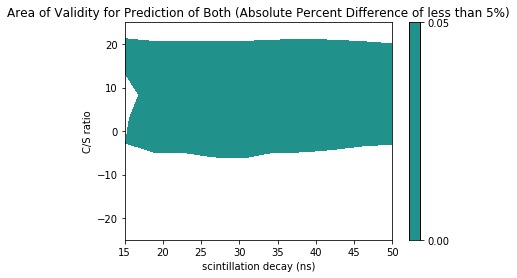

<Figure size 432x288 with 0 Axes>

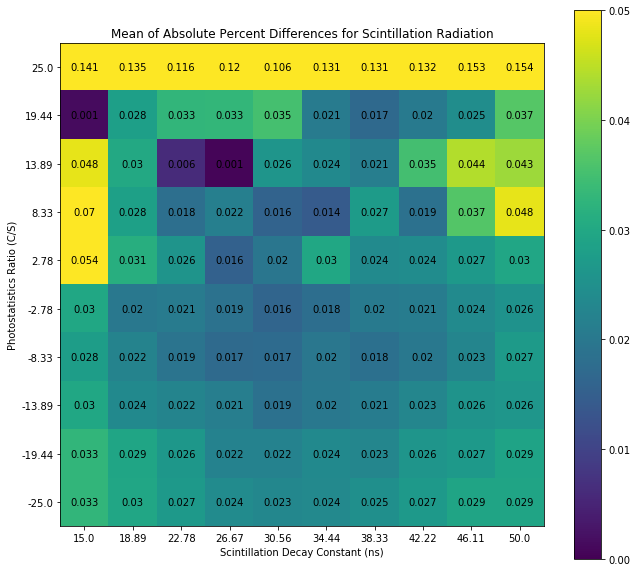

<Figure size 432x288 with 0 Axes>

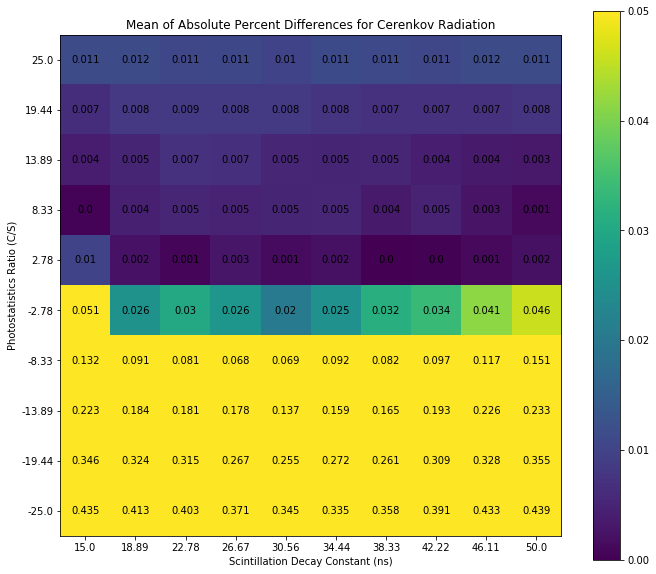

In [38]:
nn5_profile=2*(nn5_results-nn5_actual_values)/(nn5_results+nn5_actual_values)
nn5_sum_to_one=[]
nn5_profile=np.asarray(nn5_profile)
nn5_profile_labels=[]
nn5_profile_cerenkov_mean=[]
nn5_profile_scintillation_mean=[]
nn5_profile_cerenkov_stdev=[]
nn5_profile_scintillation_stdev=[]
for i in range(len(nn5_profile)):
    #print(len([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_mean.append(np.mean([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_stdev.append(np.std([item[0] for item in nn5_profile[i]]))
    nn5_profile_scintillation_mean.append(np.mean([item[1] for item in nn5_profile[i]]))
    nn5_profile_scintillation_stdev.append(np.std([item[1] for item in nn5_profile[i]]))
    nn5_profile_labels.append(nn5_labels[i][0])
    nn5_sum_to_one.append(np.mean([item[0]+item[1] for item in nn5_results[i]]))

nn5_profile_labels_clean=[]
for label in nn5_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn5_profile_labels_clean.append(label[1:index])

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean)
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev)
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean)
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev)
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean)
nn5_sum_to_one=np.asarray(nn5_sum_to_one)

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean.reshape(10,10))
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev.reshape(10,10))
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean.reshape(10,10))
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev.reshape(10,10))
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean.reshape(10,10))
nn5_sum_to_one=np.asarray(nn5_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn5_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn5_profile_cerenkov_mean, nn5_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn5_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, nn5_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_scintillation_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_scintillation_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
#plt.clim(-1,1)
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)

plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_cerenkov_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_cerenkov_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)


# 10,000 photon model on 2,000

In [39]:
nn5_results, nn5_actual_values, nn5_labels=model_verifier('FinerParameterSpace500events2000photons30binsTestingLibrary.hdf5','NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5', nn5_ratios,nn5_scint_decays,nn5_eventsperexperiment)


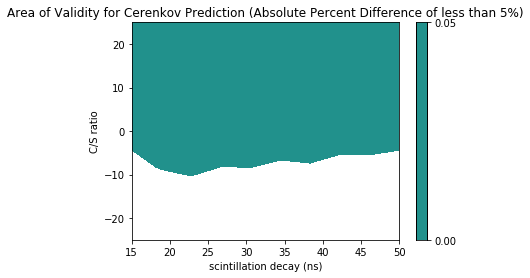

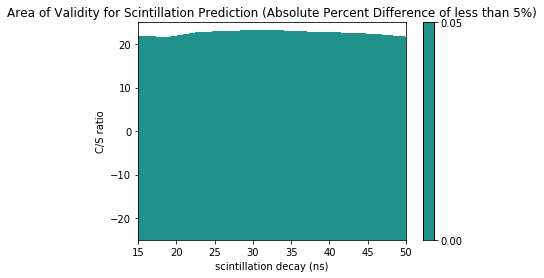

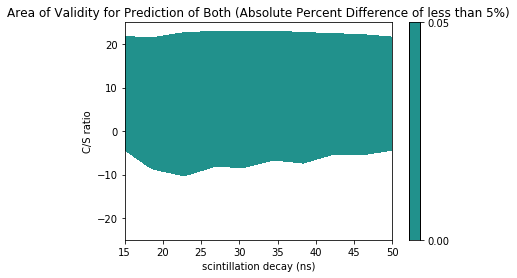

<Figure size 432x288 with 0 Axes>

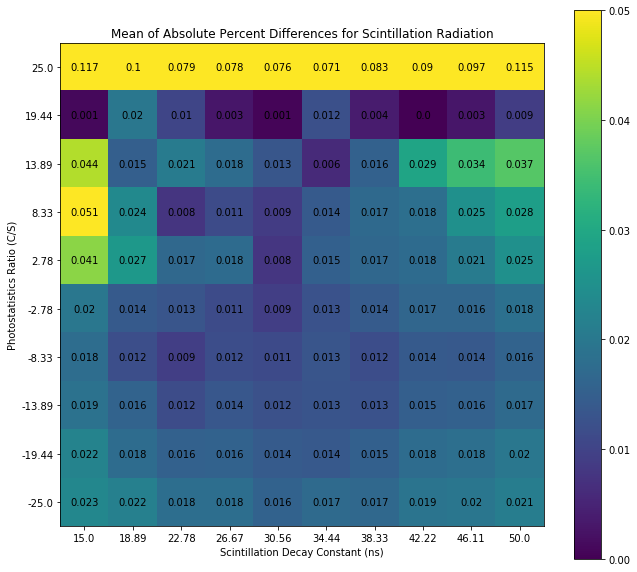

<Figure size 432x288 with 0 Axes>

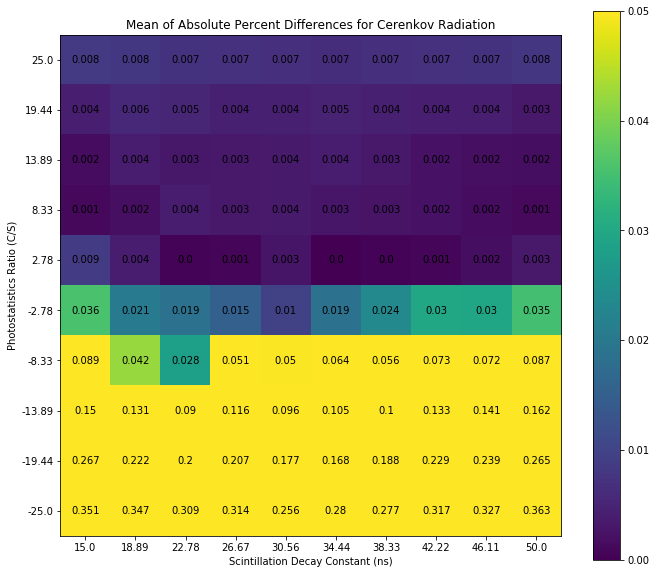

In [40]:
nn5_profile=2*(nn5_results-nn5_actual_values)/(nn5_results+nn5_actual_values)
nn5_sum_to_one=[]
nn5_profile=np.asarray(nn5_profile)
nn5_profile_labels=[]
nn5_profile_cerenkov_mean=[]
nn5_profile_scintillation_mean=[]
nn5_profile_cerenkov_stdev=[]
nn5_profile_scintillation_stdev=[]
for i in range(len(nn5_profile)):
    #print(len([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_mean.append(np.mean([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_stdev.append(np.std([item[0] for item in nn5_profile[i]]))
    nn5_profile_scintillation_mean.append(np.mean([item[1] for item in nn5_profile[i]]))
    nn5_profile_scintillation_stdev.append(np.std([item[1] for item in nn5_profile[i]]))
    nn5_profile_labels.append(nn5_labels[i][0])
    nn5_sum_to_one.append(np.mean([item[0]+item[1] for item in nn5_results[i]]))

nn5_profile_labels_clean=[]
for label in nn5_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn5_profile_labels_clean.append(label[1:index])

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean)
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev)
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean)
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev)
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean)
nn5_sum_to_one=np.asarray(nn5_sum_to_one)

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean.reshape(10,10))
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev.reshape(10,10))
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean.reshape(10,10))
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev.reshape(10,10))
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean.reshape(10,10))
nn5_sum_to_one=np.asarray(nn5_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn5_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn5_profile_cerenkov_mean, nn5_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn5_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, nn5_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_scintillation_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_scintillation_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
#plt.clim(-1,1)
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)

plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_cerenkov_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_cerenkov_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)


# 10,000 photon model on 3,000

In [41]:
nn5_results, nn5_actual_values, nn5_labels=model_verifier('FinerParameterSpace500events3000photons30binsTestingLibrary.hdf5','NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5', nn5_ratios,nn5_scint_decays,nn5_eventsperexperiment)


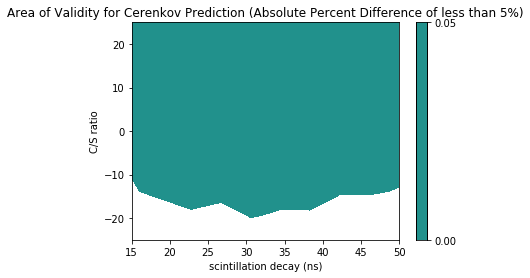

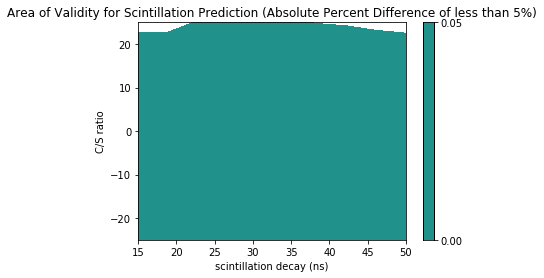

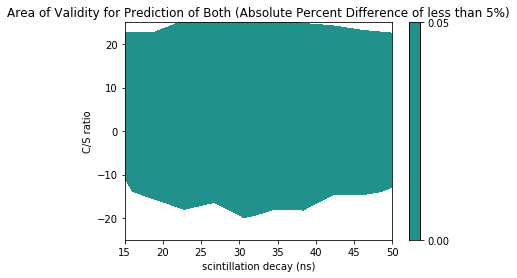

<Figure size 432x288 with 0 Axes>

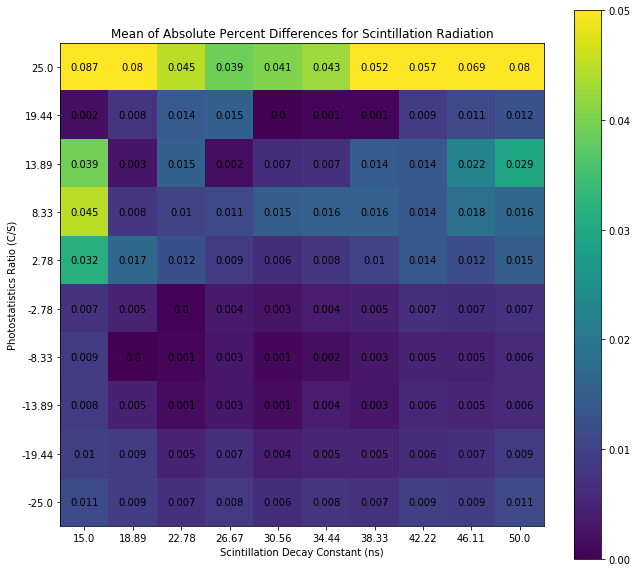

<Figure size 432x288 with 0 Axes>

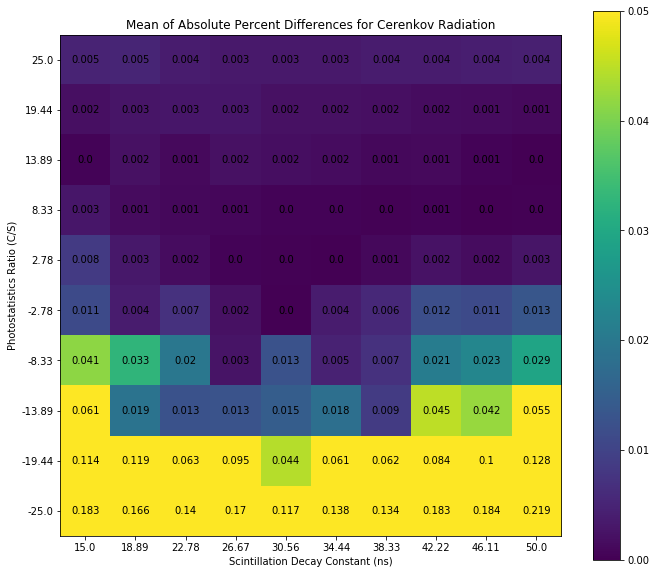

In [42]:
nn5_profile=2*(nn5_results-nn5_actual_values)/(nn5_results+nn5_actual_values)
nn5_sum_to_one=[]
nn5_profile=np.asarray(nn5_profile)
nn5_profile_labels=[]
nn5_profile_cerenkov_mean=[]
nn5_profile_scintillation_mean=[]
nn5_profile_cerenkov_stdev=[]
nn5_profile_scintillation_stdev=[]
for i in range(len(nn5_profile)):
    #print(len([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_mean.append(np.mean([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_stdev.append(np.std([item[0] for item in nn5_profile[i]]))
    nn5_profile_scintillation_mean.append(np.mean([item[1] for item in nn5_profile[i]]))
    nn5_profile_scintillation_stdev.append(np.std([item[1] for item in nn5_profile[i]]))
    nn5_profile_labels.append(nn5_labels[i][0])
    nn5_sum_to_one.append(np.mean([item[0]+item[1] for item in nn5_results[i]]))

nn5_profile_labels_clean=[]
for label in nn5_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn5_profile_labels_clean.append(label[1:index])

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean)
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev)
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean)
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev)
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean)
nn5_sum_to_one=np.asarray(nn5_sum_to_one)

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean.reshape(10,10))
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev.reshape(10,10))
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean.reshape(10,10))
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev.reshape(10,10))
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean.reshape(10,10))
nn5_sum_to_one=np.asarray(nn5_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn5_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn5_profile_cerenkov_mean, nn5_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn5_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, nn5_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_scintillation_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_scintillation_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
#plt.clim(-1,1)
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)

plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_cerenkov_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_cerenkov_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)


# 10,000 photon model on 4,000

In [43]:
nn5_results, nn5_actual_values, nn5_labels=model_verifier('FinerParameterSpace500events4000photons30binsTestingLibrary.hdf5','NarrowerParameterSpace500events10000photons30binsModel_20x20_normalized_max.hdf5', nn5_ratios,nn5_scint_decays,nn5_eventsperexperiment)


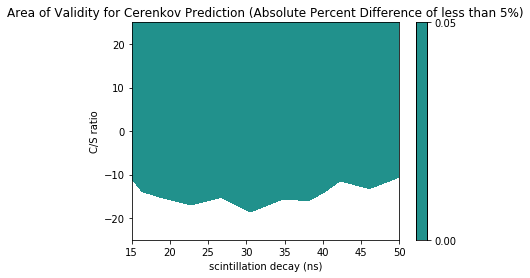

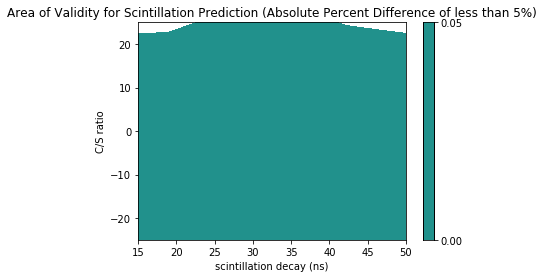

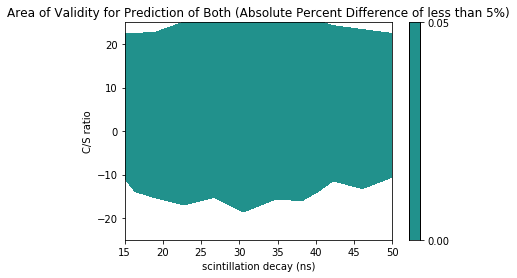

<Figure size 432x288 with 0 Axes>

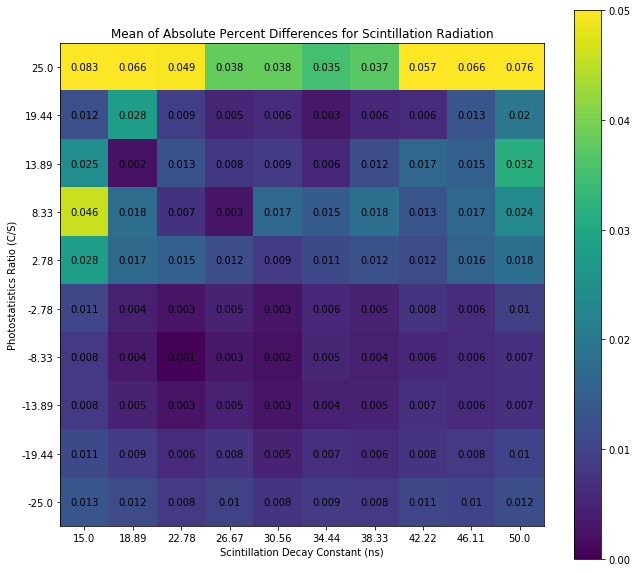

<Figure size 432x288 with 0 Axes>

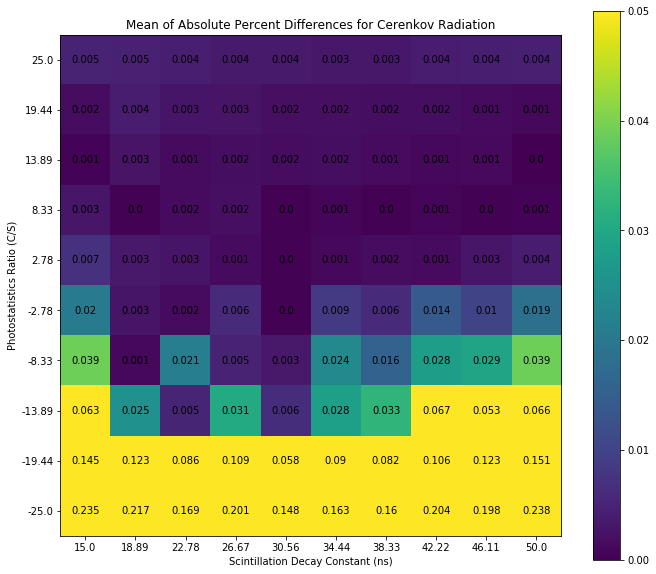

In [44]:
nn5_profile=2*(nn5_results-nn5_actual_values)/(nn5_results+nn5_actual_values)
nn5_sum_to_one=[]
nn5_profile=np.asarray(nn5_profile)
nn5_profile_labels=[]
nn5_profile_cerenkov_mean=[]
nn5_profile_scintillation_mean=[]
nn5_profile_cerenkov_stdev=[]
nn5_profile_scintillation_stdev=[]
for i in range(len(nn5_profile)):
    #print(len([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_mean.append(np.mean([item[0] for item in nn5_profile[i]]))
    nn5_profile_cerenkov_stdev.append(np.std([item[0] for item in nn5_profile[i]]))
    nn5_profile_scintillation_mean.append(np.mean([item[1] for item in nn5_profile[i]]))
    nn5_profile_scintillation_stdev.append(np.std([item[1] for item in nn5_profile[i]]))
    nn5_profile_labels.append(nn5_labels[i][0])
    nn5_sum_to_one.append(np.mean([item[0]+item[1] for item in nn5_results[i]]))

nn5_profile_labels_clean=[]
for label in nn5_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn5_profile_labels_clean.append(label[1:index])

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean)
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev)
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean)
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev)
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean)
nn5_sum_to_one=np.asarray(nn5_sum_to_one)

nn5_profile_cerenkov_mean=np.asarray(nn5_profile_cerenkov_mean.reshape(10,10))
nn5_profile_cerenkov_stdev=np.asarray(nn5_profile_cerenkov_stdev.reshape(10,10))
nn5_profile_scintillation_mean=np.asarray(nn5_profile_scintillation_mean.reshape(10,10))
nn5_profile_scintillation_stdev=np.asarray(nn5_profile_scintillation_stdev.reshape(10,10))
nn5_profile_labels_clean=np.asarray(nn5_profile_labels_clean.reshape(10,10))
nn5_sum_to_one=np.asarray(nn5_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, abs(nn5_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn5_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn5_profile_cerenkov_mean, nn5_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn5_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn5_scint_decays, nn5_ratios, nn5_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_scintillation_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_scintillation_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
#plt.clim(-1,1)
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)

plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn5_ratios)))
ax.set_xticks(np.arange(len(nn5_scint_decays)))
ax.set_yticklabels(np.round(nn5_ratios,2))
ax.set_xticklabels(np.round(nn5_scint_decays,2))
im = ax.imshow(abs(nn5_profile_cerenkov_mean))#  extent=(15, 50, 25, -25))
for i in range(len(nn5_ratios)):
    for j in range(len(nn5_scint_decays)):
        text = plt.text(j, i, abs(round(nn5_profile_cerenkov_mean[i, j],3)),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Absolute Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()
for im in plt.gca().get_images():
    im.set_clim(vmin=0, vmax=0.05)


In [ ]:
pulse=Pulse(1000,10,25)

In [ ]:
a,b,c,d=pulse.output()

In [ ]:
vals=[]

for i in range(len(d)-1):
    vals.append((d[i]+d[i+1])/2)

In [ ]:
print(len(np.linspace(0,250,100)))

In [ ]:
print(vals)